In [1]:
import os
import sys
import pickle
import h5py
import shutil
from tqdm import tqdm

import numpy as np

from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp

import powerbox as pbox

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms

import py21cmfast as p21c

import numpy as np

/home/zixuan/anaconda3/envs/dm21cm-ann/lib/python3.9/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/home/zixuan/anaconda3/envs/dm21cm-ann/lib/python3.9/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [2]:
WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)
mpl.rc_file(f"{WDIR}/matplotlibrc")

In [3]:
# check that the environment variables are set correctly
print('DM21CM_DIR:     ', os.environ['DM21CM_DIR'])      # Set to the working directory of DM21cm. This directory should contain DM21cm's `README.md`
print('DM21CM_DATA_DIR:', os.environ['DM21CM_DATA_DIR']) # Set to directory containing DM21cm's data files. This directory should contain `abscissas.h5`
print('DH_DIR:         ', os.environ['DH_DIR'])          # Set to the working directory of DarkHistory. This directory should contain DarkHistory's `README.md`
print('DH_DATA_DIR:    ', os.environ['DH_DATA_DIR'])     # Set to directory containing DarkHistory's data files. This directory should contain `binning.h5`
print('P21C_CACHE_DIR: ', os.environ['P21C_CACHE_DIR'])  # Set to directory where you want to store the 21cmFAST cache. The files for a particular run will be stored in a subdirectory of this directory.

DM21CM_DIR:      /home/zixuan/DM21cm-ann/
DM21CM_DATA_DIR: /home/zixuan/DM21cm-data/
DH_DIR:          /home/zixuan/DarkHistory-DM21cm-ann
DH_DATA_DIR:     /home/zixuan/DHdata_v1_1_full/
P21C_CACHE_DIR:  /home/zixuan/DM21cm-ann-cache/


In [4]:
def compute_power(
    box,
    length,
    n_psbins,
    log_bins=True,
    ignore_kperp_zero=True,
    ignore_kpar_zero=False,
    ignore_k_zero=False,
):
    # Determine the weighting function required from ignoring k's.
    k_weights = np.ones(box.shape, int)
    n0 = k_weights.shape[0]
    n1 = k_weights.shape[-1]

    if ignore_kperp_zero:
        k_weights[n0 // 2, n0 // 2, :] = 0
    if ignore_kpar_zero:
        k_weights[:, :, n1 // 2] = 0
    if ignore_k_zero:
        k_weights[n0 // 2, n0 // 2, n1 // 2] = 0

    res = pbox.tools.get_power(
        box,
        boxlength=length,
        bins=n_psbins,
        bin_ave=False,
        get_variance=False,
        log_bins=log_bins,
        k_weights=k_weights,
    )

    res = list(res)
    k = res[1]
    if log_bins:
        k = np.exp((np.log(k[1:]) + np.log(k[:-1])) / 2)
    else:
        k = (k[1:] + k[:-1]) / 2

    res[1] = k
    return res

In [5]:
BOX_LEN = 256  # [Mpc]

In [6]:
def powerspectra_at_k_target(brightness_temp, z_start, z_end, n_psbins=50, logk=True, k_target=0.134):
    lightcone_redshifts = brightness_temp.lightcone_redshifts
    i_start = np.argmin(np.abs(lightcone_redshifts - z_start))
    i_end = np.argmin(np.abs(lightcone_redshifts - z_end))

    chunklen = (i_end - i_start) * brightness_temp.cell_size

    power, k = compute_power(
        brightness_temp.brightness_temp[:, :, i_start:i_end],
        (BOX_LEN, BOX_LEN, chunklen),
        n_psbins,
        log_bins=logk,
    )
    
    delta = power * k ** 3 / (2 * np.pi ** 2)
    
    # Find the delta corresponding to k_target
    k_idx = np.argmin(np.abs(k - k_target))
    delta_k_target = delta[k_idx]

    return delta_k_target

In [7]:
# Read multiple LightCone objects
ddir = "/home/zixuan/DM21cm/examples/NeutrinoPortal_data"
zf_s = ['base', 'decay1', 'decay3', 'decay5']  # List of zf values

lc_s = [p21c.LightCone.read(f"{ddir}/{zf_s[i]}/lightcones.h5") for i in range(4)]

In [9]:
# Compute delta for each lightcone and z range
ps_s = []
for lc in lc_s:
    lc_results = []
    for z in tqdm(np.arange(5, 42, 1), desc="Processing Lightcone Redshifts"):
        delta_target_k = powerspectra_at_k_target(lc, z, z + 2.0, k_target=0.134)
        lc_results.append({'z': z, 'delta': delta_target_k})
    ps_s.append(lc_results)

Processing Lightcone Redshifts:   0%|                    | 0/37 [00:00<?, ?it/s]/home/zixuan/anaconda3/envs/dm21cm-ann/lib/python3.9/site-packages/powerbox/tools.py:325: UserWarning: One or more radial bins had no cells within it.
  return angular_average(
/home/zixuan/anaconda3/envs/dm21cm-ann/lib/python3.9/site-packages/powerbox/tools.py:180: RuntimeWarning: invalid value encountered in true_divide
  np.bincount(
Processing Lightcone Redshifts: 100%|███████████| 37/37 [01:05<00:00,  1.78s/it]


In [10]:
#SKA-LOW 1000h
z_SKA1000 = [15.8, 18, 20, 22, 24, 27]
delta_SKA1000 = [1, 2.7, 6.5, 15.6, 32.8, 92.2]

#SKA-LOW 100h
z_SKA100 = [12, 14, 16, 18, 20, 22, 24, 26, 27]
delta_SKA100 = [1.7, 4.2, 11, 27, 64.6, 155, 325, 640, 915]

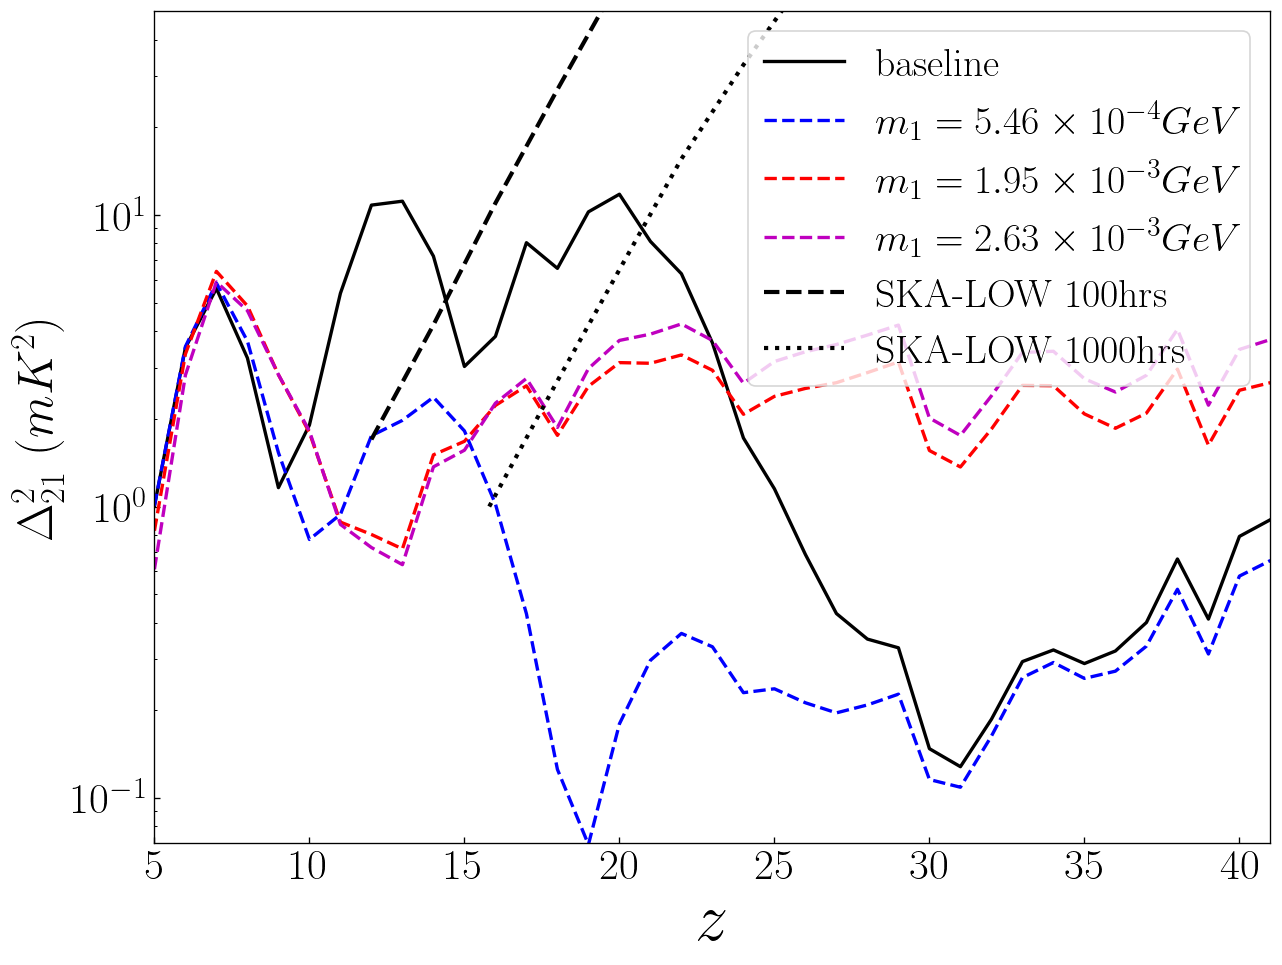

In [11]:
fig, ax = plt.subplots(figsize=(12, 9))
color_s = ['k', 'b', 'r', 'm']
zf_labels = ['baseline', r'$m_1=5.46\times10^{-4}GeV$', r'$m_1=1.95\times10^{-3}GeV$', 
             r'$m_1=2.63\times10^{-3}GeV$']

ax.set(yscale='log')
ax.set_xlabel(r'$z$', fontsize=40)
ax.set_ylabel(r'$\Delta_{21}^2\ (mK^2)$', fontsize=30)
ax.set(xlim=(5,41))
ax.set(ylim=(7e-2, 50))

for i, lc_results in enumerate(ps_s):
    z_values = [entry['z'] for entry in lc_results]
    delta_values = [entry['delta'] for entry in lc_results]
    if i==0:
      ax.plot(z_values, delta_values, color=color_s[i], label=zf_labels[i], lw=2)
    else:
      ax.plot(z_values, delta_values, color=color_s[i], label=zf_labels[i], lw=2, linestyle='--')

#SKA constraints
ax.plot(z_SKA100, delta_SKA100, color='k', label='SKA-LOW 100hrs', linestyle='--', lw=2.5)
ax.plot(z_SKA1000, delta_SKA1000, color='k', label='SKA-LOW 1000hrs', linestyle='dotted', lw=2.5)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(26)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(26)
ax.tick_params(axis='both', which='both', direction='in')
ax.tick_params(axis='both', which='both', direction='in')

ax.legend(loc="upper right", fontsize=24, bbox_to_anchor=(1,1))